In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as hr
import dionysus as d
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.tda import ClutchMapper, visualize_complex
from src.data_pipeline import query_avg, query_week
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

plt.style.use('ggplot')

init_notebook_mode(connected=True)

In [2]:
df = query_avg("HAVING position = 'TE'")
df.iloc[:100]

,id,name,pos,avg_points,avg_passing_attempts,avg_passing_completions,avg_incomplete_passes,avg_passing_yards,avg_passing_touchdowns,avg_interceptions_thrown,avg_every_time_sacked,avg_rushing_attempts,avg_rushing_yards,avg_rushing_touchdowns,avg_receptions,avg_receiving_yards,avg_receiving_touchdowns,avg_kickoff_and_punt_return_yards,avg_kickoff_and_punt_return_touchdowns,avg_fumble_recovered_for_td,avg_fumbles_lost,avg_fumble,avg_2_point_conversions,avg_pat_made,avg_pat_missed,avg_fg_made_0_19,avg_fg_made_20_29,avg_fg_made_30_39,avg_fg_made_40_49,avg_fg_made_50plus,avg_fg_missed_0_19,avg_fg_missed_20_29,avg_fg_missed_30_39,avg_fg_missed_40_49,avg_fg_missed_50plus,avg_sacks,avg_interceptions,avg_fumbles_recovered,avg_fumbles_forced,avg_safeties,avg_touchdowns,avg_blocked_kicks,avg_points_allowed,avg_yards_allowed,avg_tackle,avg_assisted_tackles,avg_sack,avg_defense_interception,avg_forced_fumble,avg_fumbles_recovery,avg_touchdown_interception_return,avg_touchdown_fumble_return,avg_touchdown_blocked_kick,avg_blocked_kick_punt_fg_pat,avg_safety,avg_pass_defended,avg_interception_return_yards,avg_fumble_return_yards,avg_qb_hit,avg_sack_yards,avg_def_2_point_return,avg_team_def_2_point_return
0,497240,Rob Gronkowski,TE,12.184615,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,5.307692,83.384615,0.615385,0.000000,0.0,0.0,0.000000,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0
1,2540258,Travis Kelce,TE,10.033333,0.066667,0.0,0.066667,0.0,0.0,0.066667,0.0,0.133333,0.466667,0.0000,5.533333,69.200000,0.533333,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.0,0.0,0.0
2,2540158,Zach Ertz,TE,9.171429,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,5.285714,58.857143,0.571429,0.000000,0.0,0.0,0.071429,0.071429,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,2557858,Evan Engram,TE,7.306667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.066667,0.933333,0.0000,4.266667,48.133333,0.400000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,497236,Jimmy Graham,TE,7.125000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,3.562500,32.500000,0.625000,0.000000,0.0,0.0,0.000000,0.000000,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
5,2555341,Hunter Henry,TE,6.825000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,3.750000,48.250000,0.333333,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
6,2495438,Kyle Rudolph,TE,6.325000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,3.562500,33.250000,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7,2495966,Delanie Walker,TE,6.281250,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.125000,-0.125000,0.0625,4.625000,50.437500,0.187500,0.000000,0.0,0.0,0.125000,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2500

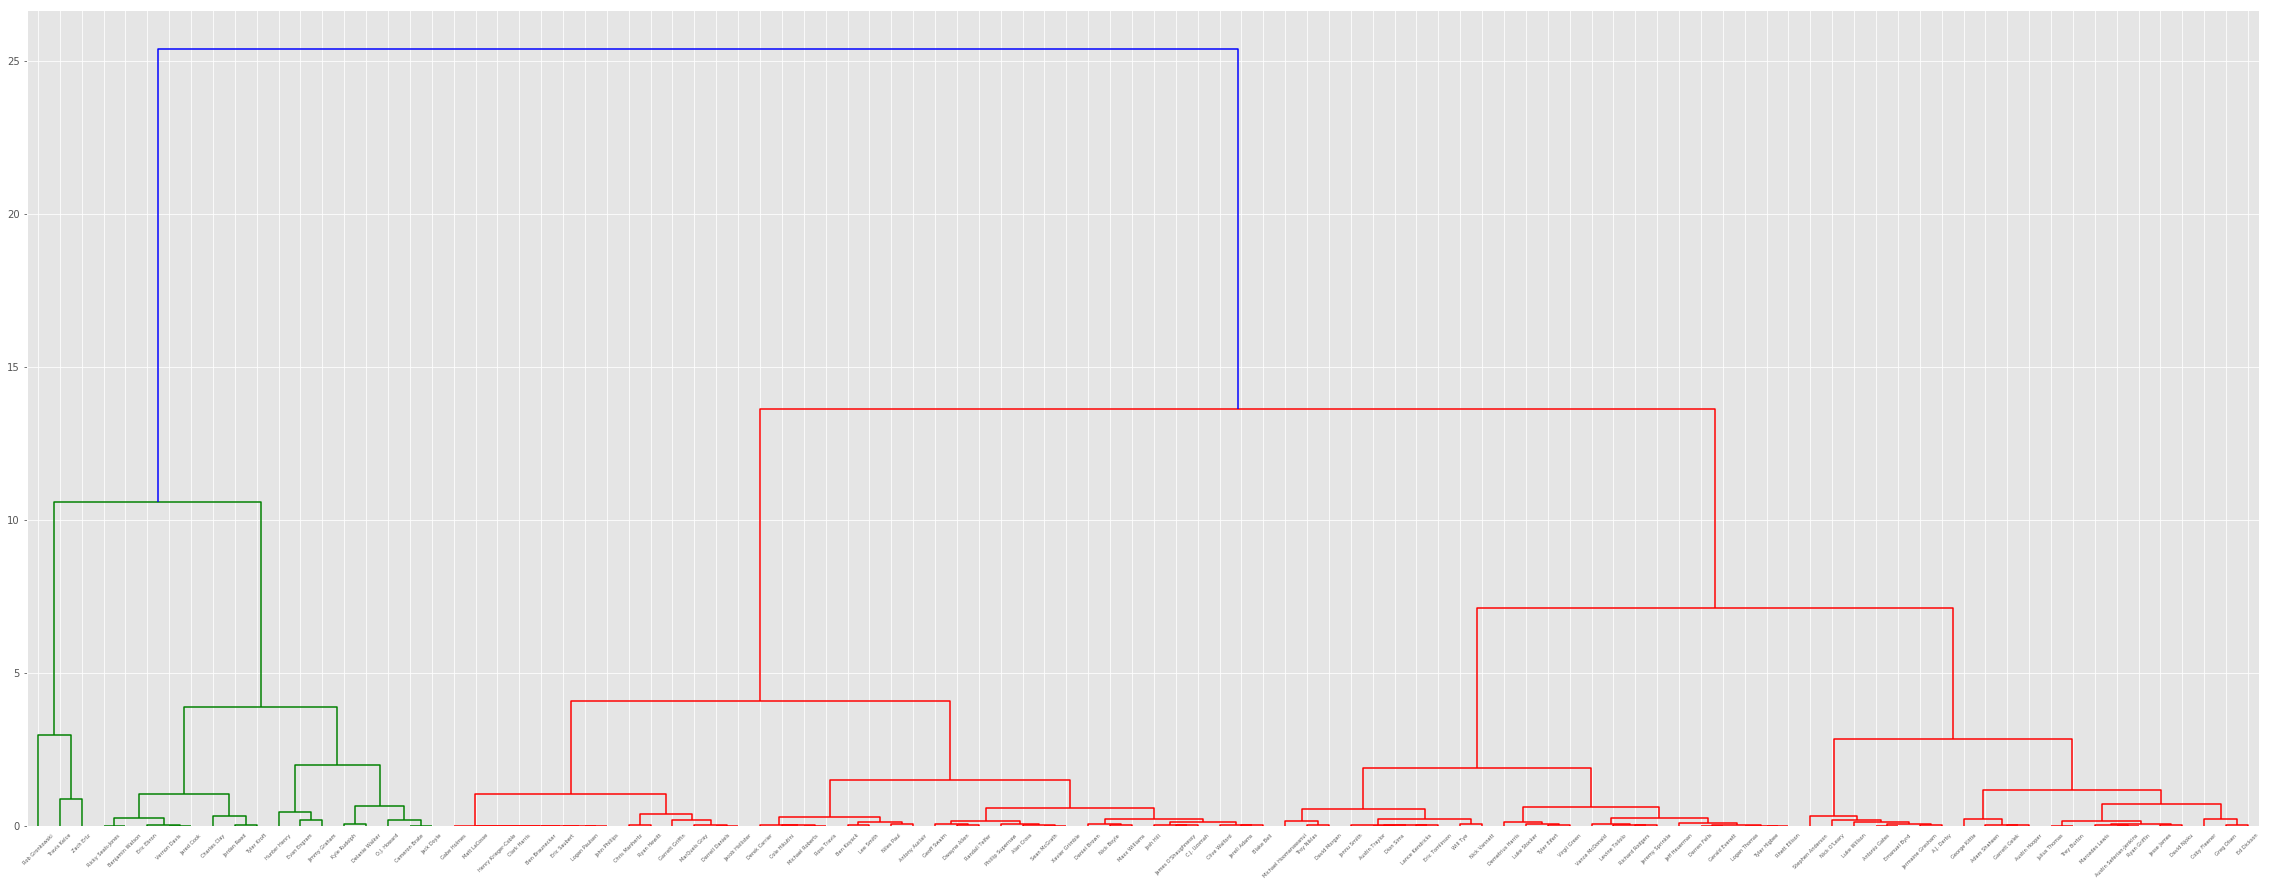

In [3]:
X = df['avg_points'].values.reshape(-1,1)
dist_vector = pdist(X, metric='euclidean')
linkage_mat = hr.linkage(dist_vector, method='ward')
plt.figure(figsize=(40,15));
dendrogram = hr.dendrogram(linkage_mat, labels=df['name'].values);
plt.xticks(rotation=45);
plt.savefig('../plots/te_avg_dendrogram.png')

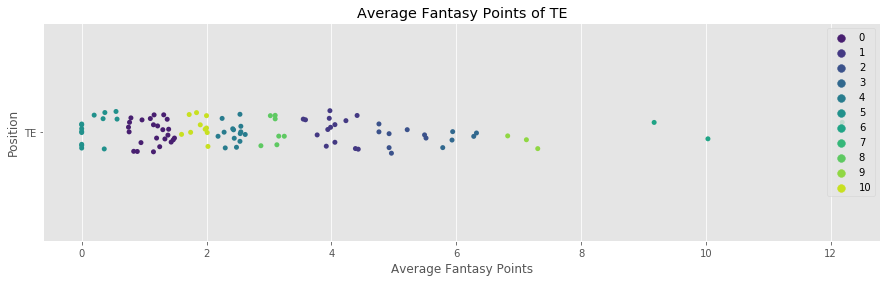

In [4]:
agg = AgglomerativeClustering(n_clusters=11, linkage='ward')
labels = agg.fit_predict(X)

plt.figure(figsize=(15,4));
plt.title('Average Fantasy Points of TE');
sns.stripplot(x="avg_points", y="pos", data=df, hue=labels, palette='viridis', jitter=True);
plt.xlabel('Average Fantasy Points');
plt.ylabel('Position');
plt.savefig('../plots/te_avg_scatter.png')

In [5]:
stats = df.iloc[:,4:].values

scaler = StandardScaler()
scaled_stats = scaler.fit_transform(stats)

cmapper = ClutchMapper()
cmapper.fit(scaled_stats, labels)

landmark_f, observer_f = cmapper.build_filtrations()

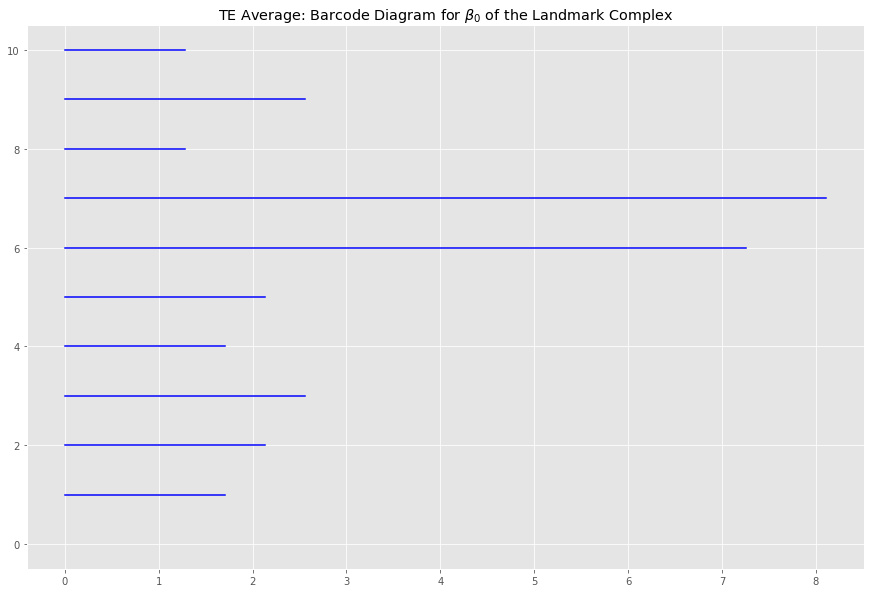

In [6]:
ph = d.homology_persistence(landmark_f)
dgms = d.init_diagrams(ph, landmark_f)

barcode_0 = plt.figure(figsize=(15,10));
plt.title('TE Average: Barcode Diagram for $\\beta_0$ of the Landmark Complex');
d.plot.plot_bars(dgms[0], show = True)
barcode_0.savefig('../plots/te_avg_barcode_landmark.png');

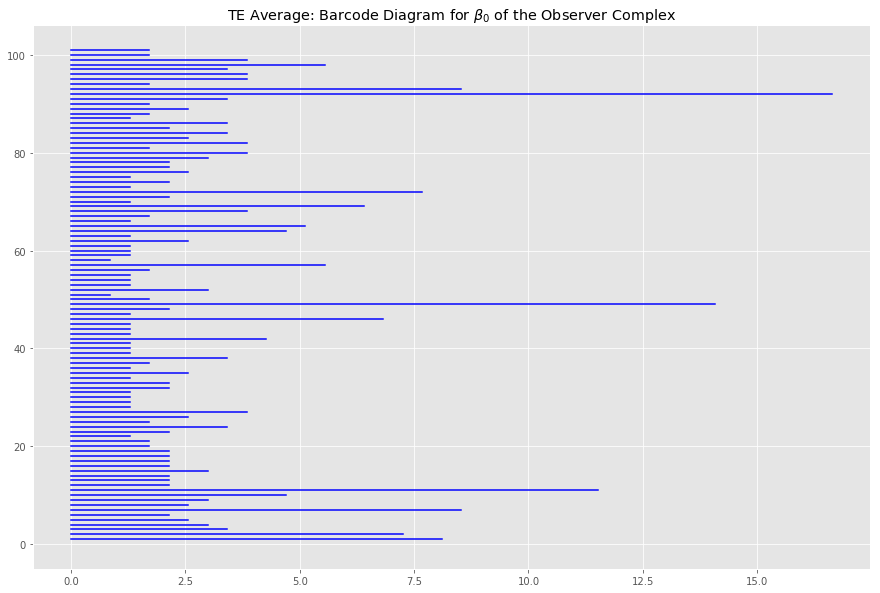

In [7]:
ph = d.homology_persistence(observer_f)
dgms = d.init_diagrams(ph, observer_f)

barcode_1 = plt.figure(figsize=(15,10));
plt.title('TE Average: Barcode Diagram for $\\beta_0$ of the Observer Complex');
d.plot.plot_bars(dgms[0], show = True)
barcode_1.savefig('../plots/te_avg_barcode_observer.png')

In [8]:
import pymongo

client = pymongo.MongoClient()
db_name = 'nfl'
db = client[db_name]
collection_name = 'complexes'
COMPLEXES = db[collection_name]
COMPLEXES.create_index([('name', pymongo.ASCENDING)], unique=True)

names = list(df['name'].values)

for i in np.arange(0,10.1,0.5):
    landmark_complex, observer_complex = cmapper.build_complex(i)

    landmark_fig = visualize_complex(landmark_complex, 'TE Average: Landmark Complex at t={}'.format(i))
    observer_fig = visualize_complex(observer_complex, 'TE Average: Observer Complex at t={}'.format(i), names)
    
    landmark_json = landmark_fig.to_plotly_json()
    observer_json = observer_fig.to_plotly_json()
    
    landmark_json['name'] = 'te_avg_landmark_complex_{}'.format(i)
    observer_json['name'] = 'te_avg_observer_complex_{}'.format(i)
    
    COMPLEXES.insert_one(landmark_json)
    COMPLEXES.insert_one(observer_json)